In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from pathlib import Path

In [5]:
# select the experiment for which you want to analyse data
experiment_id = "exp1_e0a61e8_20251004_181917"

### Load Data

In [6]:
# set the paths
current_folder = globals()['_dh'][0]
results_path = os.path.join(current_folder,f'results/{experiment_id}')
figures_path = os.path.join(current_folder,'plots')

# read the results data
df_data = pd.read_csv(os.path.join(results_path, 'iteration_history.csv'), index_col=0)
df_data_agents = pd.read_csv(os.path.join(results_path, f'agent_histories.csv'), index_col=0)

### Plot Offer and Transaction Prices

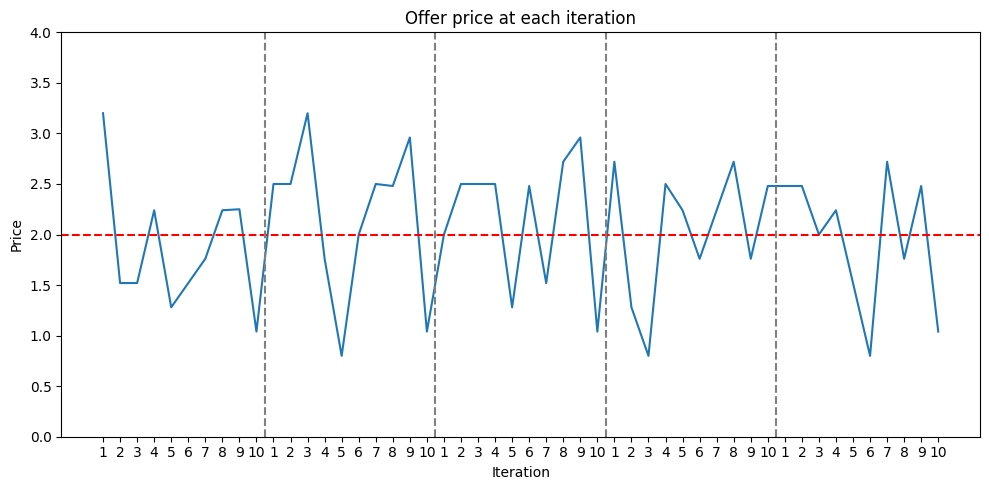

In [13]:
# collapse to one row per iteration
df_plot = (
    df_data.groupby(["round", "iteration"], as_index=False)
      .agg({
          "price": "first",    
      })
)

# plot the offer prices
plt.figure(figsize=(10, 5))
sns.lineplot(x=df_plot.index, y='price', markers='0', data=df_plot)
plt.axhline(y=2, color='red', linestyle='--')
last_indices_in_round = df_plot.groupby('round')['iteration'].apply(lambda g: g.index.max())
for x in last_indices_in_round[:-1]:
    plt.axvline(x=x+0.5, color='grey', linestyle='--', linewidth=1.5)
plt.xticks(ticks=df_plot.index, labels=df_plot['iteration'], rotation=0)
plt.title('Offer price at each iteration')
plt.xlabel('Iteration')
plt.ylabel('Price')
plt.tight_layout()
plt.ylim(0, 4)
plt.show()

In [15]:
df_plot = df_data.loc[df_data['transaction']==True].reset_index()
df_plot


,index,round,iteration,price,announcement,transaction,announcement_type,announcing_agent_id,announcing_agent_reservation_price,responding_agent_id,responding_agent_reservation_price
0,6,1,1,3.20,True,True,sell,10,3.20,10,3.20
1,12,1,2,1.52,True,True,buy,3,1.52,3,1.52
2,13,1,3,1.52,True,True,sell,0,0.80,4,1.76
3,14,1,4,2.24,True,True,buy,6,2.24,5,2.00
4,17,1,5,1.28,True,True,buy,2,1.28,2,1.28
5,18,1,6,1.52,True,True,sell,1,1.04,8,2.72
6,21,1,7,1.76,True,True,sell,4,1.76,5,2.00
7,23,1,8,2.24,True,True,buy,7,2.48,6,2.24
8,24,1,9,2.25,True,True,buy,9,2.96,7,2.48
9,33,2,1,2.50,True,True,buy,9,2.96,6,2.24


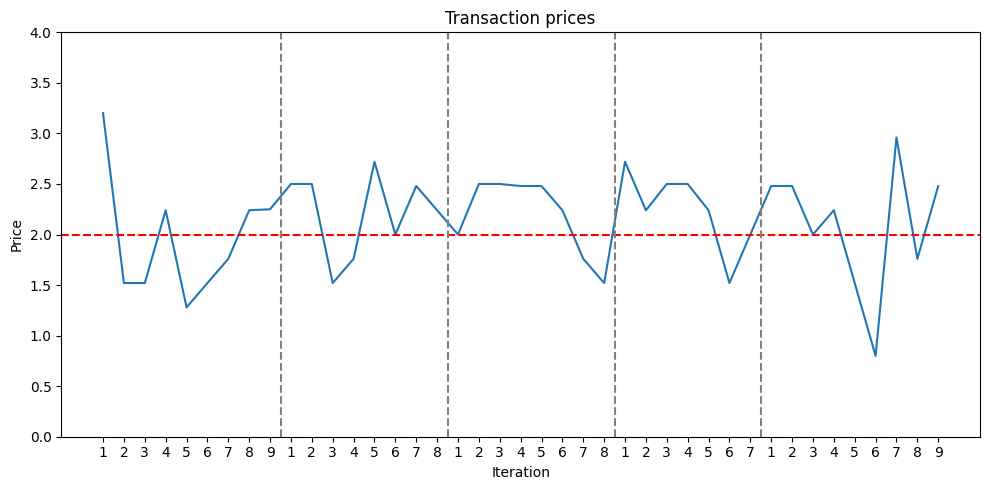

In [16]:
# plot the transaction prices
df_plot = df_data.loc[df_data['transaction']==True].reset_index()
plt.figure(figsize=(10, 5))
sns.lineplot(x=df_plot.index, y='price', markers='x', 
                data=df_plot)
plt.axhline(y=2, color='red', linestyle='--')
last_indices_in_round = df_plot.groupby('round')['iteration'].apply(lambda g: g.index.max())
for x in last_indices_in_round[:-1]:
    plt.axvline(x=x+0.5, color='grey', linestyle='--', linewidth=1.5)
plt.xticks(ticks=df_plot.index, labels=df_plot['iteration'], rotation=0)
plt.title('Transaction prices')
plt.xlabel('Iteration')
plt.ylabel('Price')
plt.tight_layout()
plt.ylim(0, 4)
plt.show()

In [17]:
# avearage prices per round
df = df_data.loc[df_data['transaction']==True].reset_index()
df.groupby('round')['price'].mean()

round
1    1.947778
2    2.215000
3    2.185000
4    2.245714
5    2.080000
Name: price, dtype: float64

In [18]:
# quantities sold per round
df = df_data.loc[df_data['transaction']==True].reset_index()
df.groupby('round')['transaction'].count()

round
1    9
2    8
3    8
4    7
5    9
Name: transaction, dtype: int64

In [19]:
# transaction price deviation from equilibrium price per round
df = df_data.loc[df_data['transaction']==True].reset_index()
df.groupby('round')['price'].std() / 2.0 * 100

round
1    29.897510
2    20.913085
3    19.203794
4    19.805002
5    32.310989
Name: price, dtype: float64

### Analyse Profits

In [24]:
# construct an implied profit column for each agents action
df_data_agents['implied_profit'] = np.where(
    df_data_agents['type'] == 'buyer',
    df_data_agents['reservation_price'] - df_data_agents['price'],  # buyer profit
    df_data_agents['price'] - df_data_agents['reservation_price']   # seller profit
)

In [36]:
# filter only the accepted offers
df_profits_realized = df_data_agents.loc[df_data_agents['outcome']=="accepted"].sort_values(by=["round", "iteration"]).reset_index(drop=True)

# Calculate profits for buyers and sellers per iteration
df = df_profits_realized.copy()

# Assuming your dataframe is called df
result = df.pivot_table(
    index=['round', 'iteration'],
    columns='type',
    values='implied_profit',
    aggfunc='first'
).reset_index()

# Rename the columns for clarity
result.columns.name = None
result = result.rename(columns={
    'buyer': 'buyer_profit',
    'seller': 'seller_profit'
})

# Add the announcer column
announcer = df[df['action'] == 'announce'].set_index(['round', 'iteration'])['type']
df_profits = result.merge(
    announcer.rename('announcer'),
    left_on=['round', 'iteration'],
    right_index=True,
    how='left'
)

print(df_profits)

    round  iteration  buyer_profit  seller_profit announcer
0       1          1          0.00           0.00    seller
1       1          2          0.00           0.00     buyer
2       1          3          0.24           0.72    seller
3       1          4          0.00           0.24     buyer
4       1          5          0.00           0.00     buyer
5       1          6          1.20           0.48    seller
6       1          7          0.24           0.00    seller
7       1          8          0.24           0.00     buyer
8       1          9          0.71          -0.23     buyer
9       2          1          0.46           0.26     buyer
10      2          2          0.70           1.70    seller
11      2          3          0.00           0.24     buyer
12      2          4          0.00           0.72     buyer
13      2          5          0.00           0.00    seller
14      2          6          0.00           0.00     buyer
15      2          7          0.00      

In [37]:
# check for negative profits
df_profits.loc[(df_profits['seller_profit']<0) | (df_profits['buyer_profit']<0)]

,round,iteration,buyer_profit,seller_profit,announcer
8,1,9,0.71,-0.23,buyer


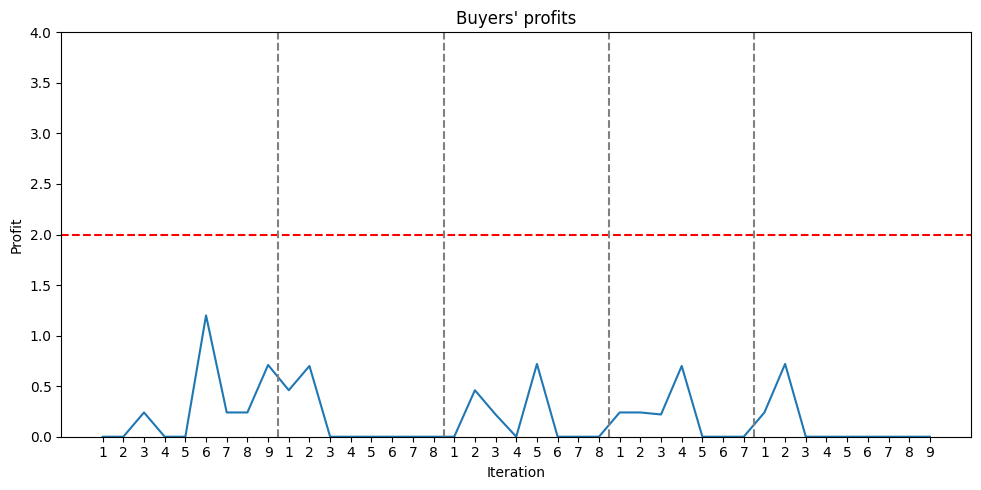

In [38]:
# plot the buyer profits
df_plot = df_profits.copy()
plt.figure(figsize=(10, 5))
sns.lineplot(x=df_plot.index, y='buyer_profit', markers='x', 
                data=df_plot)
plt.axhline(y=2, color='red', linestyle='--')
last_indices_in_round = df_plot.groupby('round')['iteration'].apply(lambda g: g.index.max())
for x in last_indices_in_round[:-1]:
    plt.axvline(x=x+0.5, color='grey', linestyle='--', linewidth=1.5)
plt.xticks(ticks=df_plot.index, labels=df_plot['iteration'], rotation=0)
plt.title("Buyers' profits")
plt.xlabel('Iteration')
plt.ylabel('Profit')
plt.tight_layout()
plt.ylim(0, 4)
plt.show()

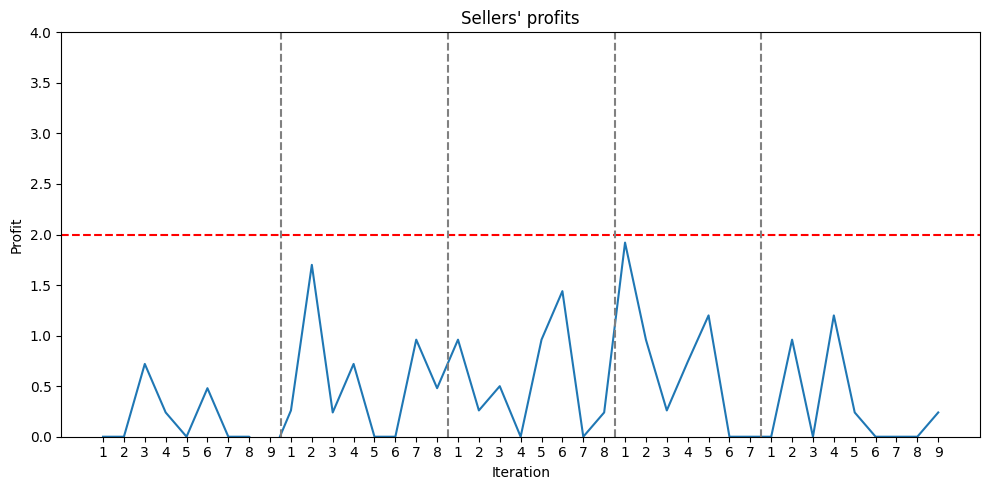

In [39]:
# plot the sellers profits
df_plot = df_profits.copy()
plt.figure(figsize=(10, 5))
sns.lineplot(x=df_plot.index, y='seller_profit', markers='x', 
                data=df_plot)
plt.axhline(y=2, color='red', linestyle='--')
last_indices_in_round = df_plot.groupby('round')['iteration'].apply(lambda g: g.index.max())
for x in last_indices_in_round[:-1]:
    plt.axvline(x=x+0.5, color='grey', linestyle='--', linewidth=1.5)
plt.xticks(ticks=df_plot.index, labels=df_plot['iteration'], rotation=0)
plt.title("Sellers' profits")
plt.xlabel('Iteration')
plt.ylabel('Profit')
plt.tight_layout()
plt.ylim(0, 4)
plt.show()

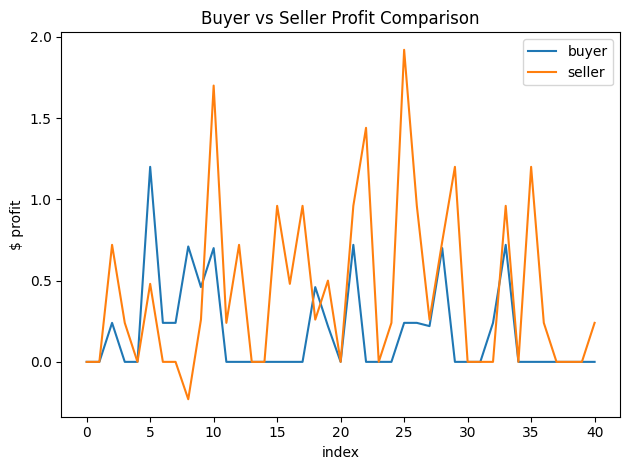

In [ ]:
# plot buyer vs seller profits
df_plot = df_profits.copy()
plt.figure()
plt.plot(df_plot.index, df_plot['buyer_profit'], label=f'buyer')
plt.plot(df_plot.index, df_plot['seller_profit'], label=f'seller')
plt.title(f"Buyer vs Seller Profit Comparison")
plt.ylabel("$ profit")
plt.xlabel("index")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# calculate announcer vs responder profits
df_profits['announcer_profit'] = np.where(
    df_profits['announcer'] == 'buyer',
    df_profits['buyer_profit'],
    df_profits['seller_profit']
)
df_profits['responder_profit'] = np.where(
    df_profits['announcer'] == 'seller',
    df_profits['buyer_profit'],
    df_profits['seller_profit']
)
df_profits

,round,iteration,buyer_profit,seller_profit,announcer,announcer_profit,responder_profit
0,1,1,0.00,0.00,seller,0.00,0.00
1,1,2,0.00,0.00,buyer,0.00,0.00
2,1,3,0.24,0.72,seller,0.72,0.24
3,1,4,0.00,0.24,buyer,0.00,0.24
4,1,5,0.00,0.00,buyer,0.00,0.00
5,1,6,1.20,0.48,seller,0.48,1.20
6,1,7,0.24,0.00,seller,0.00,0.24
7,1,8,0.24,0.00,buyer,0.24,0.00
8,1,9,0.71,-0.23,buyer,0.71,-0.23
9,2,1,0.46,0.26,buyer,0.46,0.26


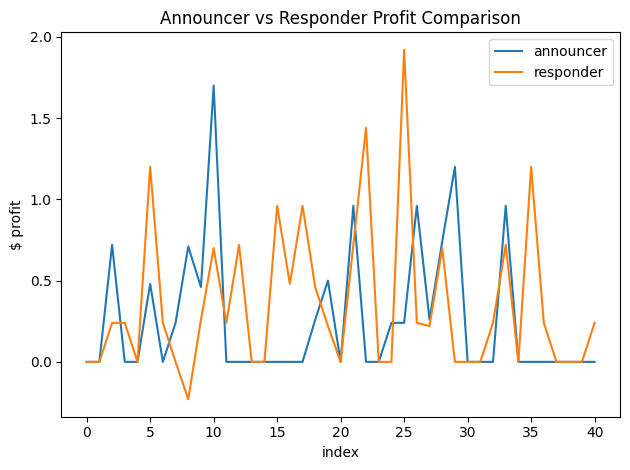

In [45]:
# plot announcer vs responders profits
df_plot = df_profits.copy()
plt.figure()
plt.plot(df_plot.index, df_plot['announcer_profit'], label=f'announcer')
plt.plot(df_plot.index, df_plot['responder_profit'], label=f'responder')
plt.title(f"Announcer vs Responder Profit Comparison")
plt.ylabel("$ profit")
plt.xlabel("index")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# compare the difference between announcer and responder profits
# vs buyer and seller profits
### FINISHED here on 04/10/2025

### Analyse Announcements

In [223]:
zero_profit_share_announcers = len(df_data.loc[df_data['announcer_profit']==0])/len(df_data)
zero_profit_share_responders = len(df_data.loc[df_data['responder_profit']==0])/len(df_data)
average_profit_announcers = df_data['announcer_profit'].mean()
average_profit_responders = df_data['responder_profit'].mean()

print(f"Share of announcers whose profit is zero: {zero_profit_share_announcers:.2f}")
print(f"Share of responders whose profit is zero: {zero_profit_share_responders:.2f}")
print("\n")
print(f"Average profit for the announcers: ${average_profit_announcers:.2f}")
print(f"Average profit for the responders: ${average_profit_responders:.2f}")

Share of announcers whose profit is zero: 0.66
Share of responders whose profit is zero: 0.20


Average profit for the announcers: $0.20
Average profit for the responders: $0.46


In [224]:
zero_profit_share_announcers_buyers = len(df_data.loc[(df_data['announcer_profit']==0) & (df_data['announcement_type']=="buy")])/len(df_data)
zero_profit_share_announcers_sellers = len(df_data.loc[(df_data['announcer_profit']==0) & (df_data['announcement_type']=="sell")])/len(df_data)

print(f"Share of buy announcers whose profit is zero: {zero_profit_share_announcers_buyers:.2f}")
print(f"Share of sell announcers whose profit is zero: {zero_profit_share_announcers_sellers:.2f}")


Share of buy announcers whose profit is zero: 0.38
Share of sell announcers whose profit is zero: 0.28


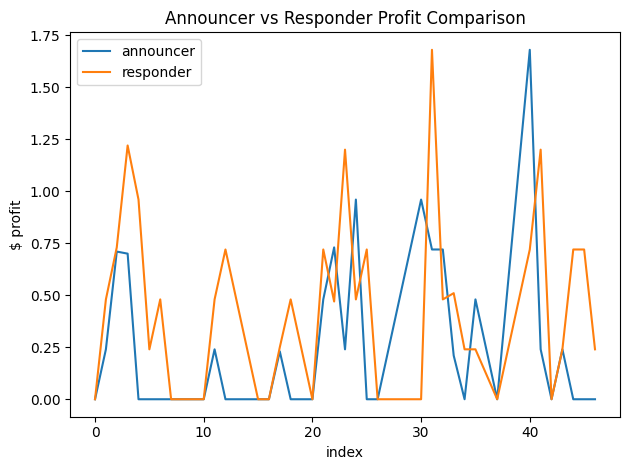

In [225]:
df = df_data.loc[df_data['transaction']==True]
plt.figure()
plt.plot(df.index, df['announcer_profit'], label=f'announcer')
plt.plot(df.index, df['responder_profit'], label=f'responder')
plt.title(f"Announcer vs Responder Profit Comparison")
plt.ylabel("$ profit")
plt.xlabel("index")
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_30380/2808244676.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['buyer_profit'] = np.nan
/tmp/ipykernel_30380/2808244676.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['seller_profit'] = np.nan


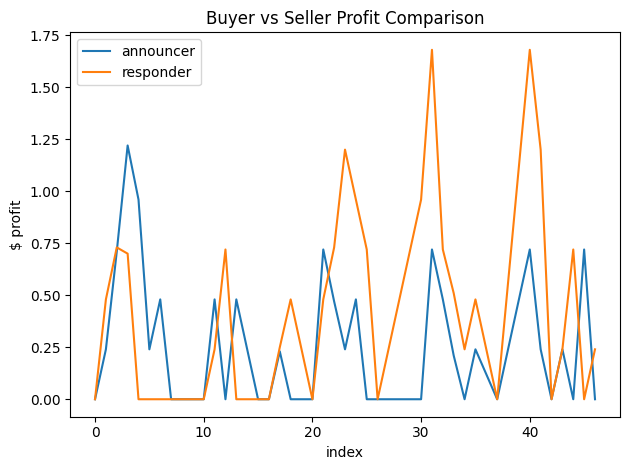

In [ ]:
df = df_data.loc[df_data['transaction']==True]
df['buyer_profit'] = np.nan
df['seller_profit'] = np.nan
df.loc[df['announcement_type'] == 'buy', 'buyer_profit'] = df['announcer_profit']
df.loc[df['announcement_type'] == 'sell', 'buyer_profit'] = df['responder_profit']
df.loc[df['announcement_type'] == 'buy', 'seller_profit'] = df['responder_profit']
df.loc[df['announcement_type'] == 'sell', 'seller_profit'] = df['announcer_profit']

plt.figure()
plt.plot(df.index, df['buyer_profit'], label=f'announcer')
plt.plot(df.index, df['seller_profit'], label=f'responder')
plt.title(f"Buyer vs Seller Profit Comparison")
plt.ylabel("$ profit")
plt.xlabel("index")
plt.legend()
plt.tight_layout()
plt.show()

### Analyse Agents' Histories

In [227]:
# calculate profits
df_data_agents = df_data_agents.reset_index(drop=True)
df_data_agents['profit'] = np.nan
df_data_agents.loc[df_data_agents['type']=='Buyer', 'profit'] = df_data_agents['reservation_price'] - df_data_agents['price']
df_data_agents.loc[df_data_agents['type']=='Seller', 'profit'] = df_data_agents['price'] - df_data_agents['reservation_price']
df_data_agents

,round,iteration,action,price,outcome,id,reservation_price,type,profit
0,1,5,respond,2.24,rejected,0,0.8,Buyer,-1.44
1,1,6,announce,0.80,rejected,0,0.8,Buyer,0.00
2,1,6,respond,2.00,rejected,0,0.8,Buyer,-1.20
3,1,7,respond,3.20,rejected,0,0.8,Buyer,-2.40
4,1,7,respond,2.48,rejected,0,0.8,Buyer,-1.68
...,...,...,...,...,...,...,...,...,...
818,5,10,respond,1.28,rejected,10,3.2,Seller,-1.92
819,5,10,announce,3.20,rejected,10,3.2,Seller,0.00
820,5,10,respond,0.80,rejected,10,3.2,Seller,-2.40
821,5,10,respond,1.76,rejected,10,3.2,Seller,-1.44


In [228]:
df_data_agents['counter'] = df_data_agents.groupby(['type', 'id']).cumcount()

In [229]:
df_data_agents

,round,iteration,action,price,outcome,id,reservation_price,type,profit,counter
0,1,5,respond,2.24,rejected,0,0.8,Buyer,-1.44,0
1,1,6,announce,0.80,rejected,0,0.8,Buyer,0.00,1
2,1,6,respond,2.00,rejected,0,0.8,Buyer,-1.20,2
3,1,7,respond,3.20,rejected,0,0.8,Buyer,-2.40,3
4,1,7,respond,2.48,rejected,0,0.8,Buyer,-1.68,4
...,...,...,...,...,...,...,...,...,...,...
818,5,10,respond,1.28,rejected,10,3.2,Seller,-1.92,82
819,5,10,announce,3.20,rejected,10,3.2,Seller,0.00,83
820,5,10,respond,0.80,rejected,10,3.2,Seller,-2.40,84
821,5,10,respond,1.76,rejected,10,3.2,Seller,-1.44,85


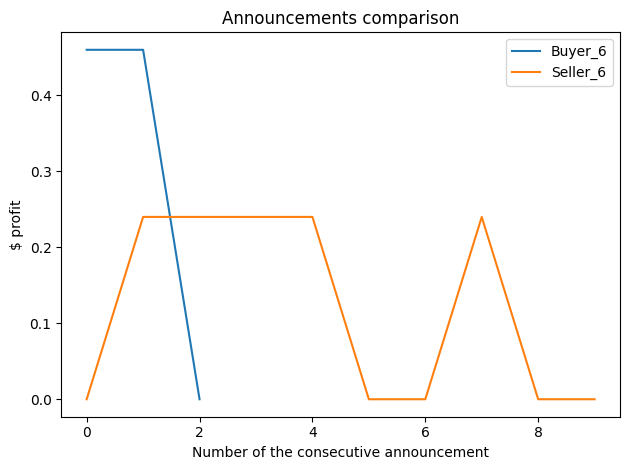

In [230]:
d_announcements = {}
for agent_id in range(0,11):
    for agent_type in ['Buyer', 'Seller']:
        df = df_data_agents.loc[
            (df_data_agents['id']==agent_id) & 
            (df_data_agents['type']==agent_type) & 
            (df_data_agents['action']=='announce')]
        df.loc[:, 'counter'] = df.groupby(['type', 'id']).cumcount()
        d_announcements[f'{agent_type}_{agent_id}'] = df


agent_id = 6
plt.figure()
plt.plot(d_announcements[f'Buyer_{agent_id}']['counter'], d_announcements[f'Buyer_{agent_id}']['profit'], label=f'Buyer_{agent_id}')
plt.plot(d_announcements[f'Seller_{agent_id}']['counter'], d_announcements[f'Seller_{agent_id}']['profit'], label=f'Seller_{agent_id}')
plt.title(f"Announcements comparison")
plt.ylabel("$ profit")
plt.xlabel("Number of the consecutive announcement")
plt.legend()
plt.tight_layout()
plt.show()


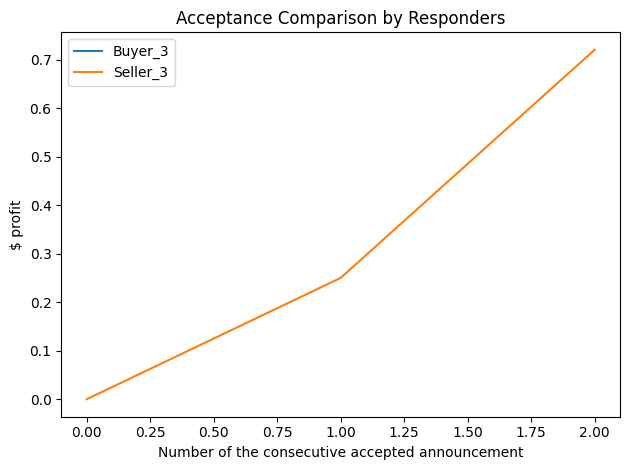

In [231]:
d_announcements = {}
for agent_id in range(0,11):
    for agent_type in ['Buyer', 'Seller']:
        df = df_data_agents.loc[
            (df_data_agents['id']==agent_id) & 
            (df_data_agents['type']==agent_type) & 
            (df_data_agents['action']=='respond') & 
            (df_data_agents['outcome']=='accepted')]
        df.loc[:, 'counter'] = df.groupby(['type', 'id']).cumcount()
        d_announcements[f'{agent_type}_{agent_id}'] = df


agent_id = 3
plt.figure()
plt.plot(d_announcements[f'Buyer_{agent_id}']['counter'], d_announcements[f'Buyer_{agent_id}']['profit'], label=f'Buyer_{agent_id}')
plt.plot(d_announcements[f'Seller_{agent_id}']['counter'], d_announcements[f'Seller_{agent_id}']['profit'], label=f'Seller_{agent_id}')
plt.title(f"Acceptance Comparison by Responders")
plt.ylabel("$ profit")
plt.xlabel("Number of the consecutive accepted announcement")
plt.legend()
plt.tight_layout()
plt.show()
